In [373]:
# Librairies
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

import pickle
import time
from sklearn.model_selection import GridSearchCV


In [374]:

df = pd.read_csv('bus_trafic_clean.csv')
df = df.astype({"horodatage": "datetime64",
                "horodatage_maj": "datetime64",
                "Heure_estimee_de_passage_a_L_arret": "datetime64",
                "date_heure": "datetime64",
                "date": "datetime64",
                "date_heure": "datetime64",
                "numero_de_parc_du_vehicule": "category"
                })

## Préparation des données

In [ ]:
#Sélection des variables
df_RLM = df[['date',
             'ecart_horaire_en_secondes',
             'nom_de_la_ligne', 
             'etat_SAE_du_vehicule',
             'month',
             'day',
             'jour_semaine',
             'OPINION']]

# transfo saisonnalité 
df_RLM['day'] = (df_RLM['day']) * (1/31)
df_RLM['month'] = (df_RLM['month'] - 7) * (1/5)
Days = {'Lundi': 1/7, 'Mardi': 2/7, 'Mercredi': 3/7, 'Jeudi': 4/7, 'Vendredi': 5/7, 'Samedi': 6/7, 'Dimanche': 7/7}
df_RLM['jour_semaine'] = df_RLM['jour_semaine'].map(Days)

# différence en secondes entre l'heure estimée de passage et l'horodatage
df_RLM['diff_estimee'] = (
    df['Heure_estimee_de_passage_a_L_arret'] - df['horodatage']).dt.total_seconds() / 60

# différence en secondes entre l'horodatage et sa mise à jour
df_RLM['diff_maj'] = -(
    df['horodatage_maj'] - df['horodatage']).dt.total_seconds() / 60

Explications de prédiction.

On veut prédire la qualité du trafic le jour suivant, cela implique de grouper nos données par jour (saisonnalité journalière)  cette opération est destructrice puisqu'elle ne permet pas reconstrituer les données d'origine.

Notre modèle doit pouvoir prédire le trafic du jour suivant en se basant sur les données de la veille. Nous pourions  inclure les données des jours précédents avec un modèle LSTM qui est parfaitment adapaté à des données temporelles. Mais nous n'avons pas assez de données pour un modèle LSTM (uniquement 125 jours d'observations).

Revenons sur la consigne, nous devons prédire "la qualité du trafic le jour suivant". 
Plaçons nous dans la vision d'un utilisateur du reseau de tram et de bus, il souhaite savoir si le trafic sera bon ou mauvais le lendemain.Généralement, un utilisateur utilise toujours la même ligne de tram ou de bus, qu'il utilise pour faire l'aller puis le retour. Nous réaliserons donc des **prévisions par lignes**, puisque qu'une prédiction globale n'a que peu d'interêt pour l'utilisateur et qu'une prédiction précise nécessite plus de données.


Pour symboliser la qualité du trafic, nous allons utiliser la variable "ecart_horaire_en_secondes" qui est une variable numérique. Cela implique d'utiliser un modèle de régression.
Pour pouvoir aggréger ces données par jours, nous choisissons l'aggrégation de somme, cela permettra de mettre en avant la variabilité entre les lignes. Puisque plus une ligne est utilisée, plus le nombre de bus à son service est haut et donc plus de requêtes la concernant sont effectuées. Ainsi si une ligne est très utilisée et a de nombreux retards alors sa somme des écarts sera très importante. Cela permettra de pénalisé à hauteur de la fréquentation de la ligne. (selon l'hypothèse  bcp de voyageurs => bcp de bus en activité sur cette ligne )  

Résumé : en entrée nous aurons les données aggrégés de la veille en globale et les dernières données aggrégé par ligne, ainsi que la ligne que nous souhaitons prédire, en sortie nous aurons la somme des écarts horaires de la ligne que nous souhaitons prédire.

In [376]:
# Si le bus/tram est arrivé en avance, on considère que l'écart horaire est nul
df_RLM['ecart_horaire_en_secondes'] = df_RLM['ecart_horaire_en_secondes'].apply(lambda x: 0 if x < 0 else x)

# Aggrégation par jour et par ligne
df_group = df_RLM.groupby(['date','nom_de_la_ligne']).agg(
    {'ecart_horaire_en_secondes' : 'sum',
     'diff_estimee' : 'sum',
     'diff_maj' : 'sum',
     'month' : 'first',
     'day' : 'first',
     'jour_semaine' : 'first',
     'OPINION' : 'first'
    }).merge((df_RLM
  .groupby(["date",'nom_de_la_ligne', 'etat_SAE_du_vehicule'])
  .size()
  .unstack('etat_SAE_du_vehicule', fill_value=0)
  .add_prefix("nombre_etat_")
), on=['date','nom_de_la_ligne'], how='left')
    
# Les valeurs d'écarts prochaines pour chaque ligne
df_group['next_ecart'] = df_group.groupby('nom_de_la_ligne')['ecart_horaire_en_secondes'].shift()
df_group.dropna(inplace=True)       
  
df_group.reset_index(inplace=True, level=['nom_de_la_ligne'])
  
#Ajout données globales de la veille  
df_group.merge(
  df_RLM.groupby('date').agg({
    'ecart_horaire_en_secondes' : 'sum',
     'diff_estimee' : 'sum',
     'diff_maj' : 'sum',  }).rename(columns=
                  {'ecart_horaire_en_secondes': 'ecart_horaire_en_secondes_global',
                   'diff_estimee' : 'diff_estimee_global',
                   'diff_maj' : 'diff_maj_global'}), on=['date'], how='left'
)



C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/2544959590.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,nom_de_la_ligne,ecart_horaire_en_secondes,diff_estimee,diff_maj,month,day,jour_semaine,OPINION,nombre_etat_DEV,nombre_etat_DEVP,...,nombre_etat_HLPS,nombre_etat_HS,nombre_etat_INC,nombre_etat_LIGN,nombre_etat_TARR,nombre_etat_TDEP,next_ecart,ecart_horaire_en_secondes_global,diff_estimee_global,diff_maj_global
date,,,,,,,,,,,,,,,,,,,,,
2019-08-06,A - Remplacement Tram par Bus,78928.0,-4483.016667,4.600000,0.2,0.193548,0.285714,météo défavorable,0,0,...,2,0,0,391,20,71,6657.0,541466.0,-62200.433333,43.333333
2019-08-06,ARDENNE <> ROSERAIE,16712.0,-2698.450000,2.383333,0.2,0.193548,0.285714,météo défavorable,0,0,...,0,0,0,247,6,51,5554.0,541466.0,-62200.433333,43.333333
2019-08-06,BEAUCOUZE <> ST BARTHELEMY,41219.0,-4572.566667,3.516667,0.2,0.193548,0.285714,météo défavorable,3,21,...,1,0,0,350,43,19,3455.0,541466.0,-62200.433333,43.333333
2019-08-06,BELLE BEILLE <> MONPLAISIR,82449.0,-5539.166667,3.233333,0.2,0.193548,0.285714,météo défavorable,0,16,...,26,0,0,327,26,29,2278.0,541466.0,-62200.433333,43.333333
2019-08-06,BOUCHEMAINE <> Z I EST,25609.0,-3205.250000,2.733333,0.2,0.193548,0.285714,météo défavorable,6,42,...,3,0,0,233,22,22,1450.0,541466.0,-62200.433333,43.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-12,ST CLEMENT St LAMBERT <> GARE,2952.0,-724.939450,0.289450,1.0,0.387097,0.571429,météo très défavorable,0,0,...,3,0,0,9,1,3,7175.0,594429.0,-11201.759250,56.009250
2019-12-12,ST LEGER St LAMBERT <> GARE,7363.0,344.847350,0.669317,1.0,0.387097,0.571429,météo très défavorable,0,0,...,13,0,0,30,3,1,9280.0,594429.0,-11201.759250,56.009250
2019-12-12,ST LEZIN SORGES <> SCHWEITZER,21372.0,349.456900,2.859767,1.0,0.387097,0.571429,météo très défavorable,0,0,...,22,0,0,151,7,23,71377.0,594429.0,-11201.759250,56.009250


In [377]:
df_group.groupby(['date']).agg(
    {'nom_de_la_ligne' : "nunique"}).describe()

,nom_de_la_ligne
count,127.000000
mean,28.488189
std,9.579961
min,1.000000
25%,30.000000
50%,32.000000
75%,34.000000
max,36.000000


Problème : certains jours, il n'y a que très peu de lignes de bus actives. et certaines lignes de bus n'ont que très peu de données.
Gardons uniquement les 15 lignes de bus les plus actives. (afin d'inclure les trams qui sont constitue la 14ème ligne la plus utilisée)

In [378]:
lignes_keep = df_RLM['nom_de_la_ligne'].value_counts().index[:15]
df_group = df_group[df_group['nom_de_la_ligne'].isin(lignes_keep)]

In [379]:
# One Hot Encoding
df_group = pd.get_dummies(df_group, columns=['OPINION','nom_de_la_ligne'])
df_group.shape

(1508, 40)

In [380]:
df_group.head()

,ecart_horaire_en_secondes,diff_estimee,diff_maj,month,day,jour_semaine,nombre_etat_DEV,nombre_etat_DEVP,nombre_etat_GARE,nombre_etat_HC,...,nom_de_la_ligne_BOUCHEMAINE <> Z I EST,nom_de_la_ligne_CIRCULAIRE VERNEAU GARE EUROPE,nom_de_la_ligne_ESPACE ANJOU <> EVENTARD,nom_de_la_ligne_HOPITAL <> MONTREUIL JUIGNE,nom_de_la_ligne_LAC MAINE <> STE GEMMES CL ANJOU,nom_de_la_ligne_M-MARCILLE <> ST AUBIN LA SALLE,nom_de_la_ligne_MURS ERIGNE <> ADEZIERE SALETTE,nom_de_la_ligne_PONTS CE <> AQUAVITA H. RECULEE,nom_de_la_ligne_ST LEZIN SORGES <> SCHWEITZER,nom_de_la_ligne_ST SYLVAIN BANCHAIS <>TRELAZE
date,,,,,,,,,,,,,,,,,,,,,
2019-08-06,78928.0,-4483.016667,4.600000,0.2,0.193548,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-06,16712.0,-2698.450000,2.383333,0.2,0.193548,0.285714,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-06,41219.0,-4572.566667,3.516667,0.2,0.193548,0.285714,3,21,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-06,82449.0,-5539.166667,3.233333,0.2,0.193548,0.285714,0,16,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-08-06,25609.0,-3205.250000,2.733333,0.2,0.193548,0.285714,6,42,0,0,...,1,0,0,0,0,0,0,0,0,0


# Modèle Prophet

Dans un premier temps, essayons de prédire la variable expliqué avec uniquement la variable date. 
Pour cela, nous allons utiliser le modèle Prophet de Facebook. Ce modèle est basé sur la décomposition de la série temporelle en trois composantes : tendance, saisonnalité et bruit. Il est donc particulièrement adapté à la prédiction de séries temporelles à condition qu'il y ait un lien entre la variable à expliqué et la date.

In [381]:
m = Prophet()

df_prophet = df_group['next_ecart'].reset_index()
#df_prophet = df_prophet.drop_duplicates(subset='date', keep='first')

df_prophet = df_prophet.rename(
    columns={'date': 'ds', 'next_ecart': 'y'})

In [382]:
train , test = train_test_split(df_prophet, test_size=0.2, random_state=0)
m.fit(train)

00:14:26 - cmdstanpy - INFO - Chain [1] start processing
00:14:26 - cmdstanpy - INFO - Chain [1] done processing


Nous allons utilisés comme indicateurs de performances : MSE, MAE et MAP.
Il est important de pouvoir évaluer nos différents modèles de prédiction par rapport à une prédiction naive. 

Pour réaliser nos prédictions nous avons de nombreuses variables de différents types, de très nombreuses variables qualitatives ainsi qu'une donnée GPS et des dates. 

##### Prédiction par la moyenne

In [383]:
mean_pred = pd.Series([train['y'].mean()] * len(test))
y = test['y']

print(
    "r2_score : ", r2_score(y, mean_pred))
print(
    'mean_squared_error : ', mean_squared_error(y, mean_pred))
print(
    'mean_absolute_error : ', mean_absolute_error(y, mean_pred))
print(
    'mean_absolute_percentage_error', mean_absolute_percentage_error(y, mean_pred))

r2_score :  -0.002895299551583852
mean_squared_error :  2280829703.0098367
mean_absolute_error :  36980.90360010104
mean_absolute_percentage_error 2.4662786367765173


##### Prédiction par modèle Prophet

In [384]:
predictions = m.predict(test[['ds']])
predictions = predictions['yhat']
y = test['y']

print(
    "r2_score : ", r2_score(y, predictions))
print(
    'mean_squared_error : ', mean_squared_error(y, predictions))
print(
    'mean_absolute_error : ', mean_absolute_error(y, predictions))
print(
    'mean_absolute_percentage_error', mean_absolute_percentage_error(y, predictions))


r2_score :  -0.17015908501995325
mean_squared_error :  2661228544.5486283
mean_absolute_error :  40416.11121369944
mean_absolute_percentage_error 1.5252035586863324


En comparant les résultats de la prédiction par la moyenne et par le modèle Prophet, on peut voir que le modèle Prophet a des performances excécrables. 

Cela est dû au fait que l'horodatage ne contient peu ou pas d'information sur la variable à expliqué ou que la connaissance n'est disponible que par combinaisons avec d'autres variables.

Nous pourions utiliser le modèle Prophet pour expliquer la saisonnalité et la tendance, puis entrainer des modèles de régression sur les résidus. Cependant, il s'agit d'un modèle inutilement complexe pour le nombre d'observations limités que nous avons.

Continuons dans les modèles explicables avec une régression linéaire multiple qui implique un lien linéaire entre la variable à expliqué et les variables explicatives.

# Modèle de Régression linéaire Multiple

Nous avons limité lors du croisement des données, en effet nos données ont été collectés en 2019, il en résulte une incompatibilité avec les données GTFS de parcours des lignes ainsi que les coordonnées des arrêts.

In [385]:
Xtrain , Xtest , Ytrain , Ytest = train_test_split(df_group.drop('next_ecart', axis=1), df_group['next_ecart'], test_size = 0.2, random_state = 0)

collones = df_group.columns.drop('next_ecart')

In [386]:
poly = PolynomialFeatures(degree=2, interaction_only=True)
poly.fit(Xtrain)
Xtrain_poly = poly.transform(Xtrain)
Xtest_poly = poly.transform(Xtest)
Xtrain_poly.shape

(1206, 781)

Nous avons essayer de tirer les liens polynomiales entre nos variables et la variable à expliquer par combinaisons de nos variables entre elles et avec elles même. Cependant, il en ressort 781 collones à cause de nos variables qualitative mis en one-hot-encoding. 
Ce qui détruirait l'explicabilité, alors que cela est l'objectif d'avoir un modèle simple.

In [387]:
#On remets les noms de collones
Xtrain = pd.DataFrame(Xtrain, columns= collones)
Xtest = pd.DataFrame(Xtest, columns= collones)

Nous avons en entrée la matrix Xtrain et un vecteur Ytrain pour chaque variable $X[:, i]$ calculons $\rho_i = \frac{(X[:, i] - mean(X[:, i])) * (y - mean(y))}{std(X[:, i]) * std(y)} $ auquel on associe la F-statistique $F_i = \frac{\rho_i^2}{1 - \rho_i^2}*(n-2)$

In [388]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

# On affiche les 10 variables les plus liés à la variable à expliquer
select = SelectKBest(f_regression, k=10)
select.fit(Xtrain, Ytrain)

features = zip(list(Xtrain.columns[select.get_support(indices=True)]), list(
    select.scores_[select.get_support(indices=True)]))
print('Meilleures variables avec p-value: %s' % list(features))




Meilleures variables avec p-value: [('ecart_horaire_en_secondes', 1007.055970336363), ('diff_estimee', 143.95572558308442), ('month', 112.0638593804714), ('jour_semaine', 91.72215406648475), ('nombre_etat_DEVP', 84.53323615027239), ('nombre_etat_HLP', 82.70482133467279), ('nombre_etat_HLPR', 172.20186154146498), ('nombre_etat_LIGN', 759.0631600159452), ('nombre_etat_TDEP', 146.70347855402304), ('nom_de_la_ligne_BELLE BEILLE <> MONPLAISIR', 412.5845178919786)]


c:\Users\OkaTravaille\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning:

invalid value encountered in true_divide



On remarque des variables cohérentes avec la variable à estimé. Mais les p-values sont plutot faible, le lien linéaire n'est pas très fort.

In [389]:
#rename des var à l'arrache.
X_train = Xtrain 
X_test = Xtest 
y_train = Ytrain 
y_test = Ytest

Copie des précédents modèles.

In [390]:
df_result = pd.DataFrame(columns=["model", "CV", "R2", "MSE", "MAE", "MAPE", "Temps d'execution"])

In [391]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

time_start = time.time()

lr= LinearRegression()

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["lr", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

R2:  0.694483279422363
MSE:  694819899.3167077
MAE:  20698.51342716361
MAPE:  0.6061101185146829


C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/3482457100.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



<AxesSubplot: title={'center': 'Coefficients de la régression linéaire'}, xlabel='Coefficient'>

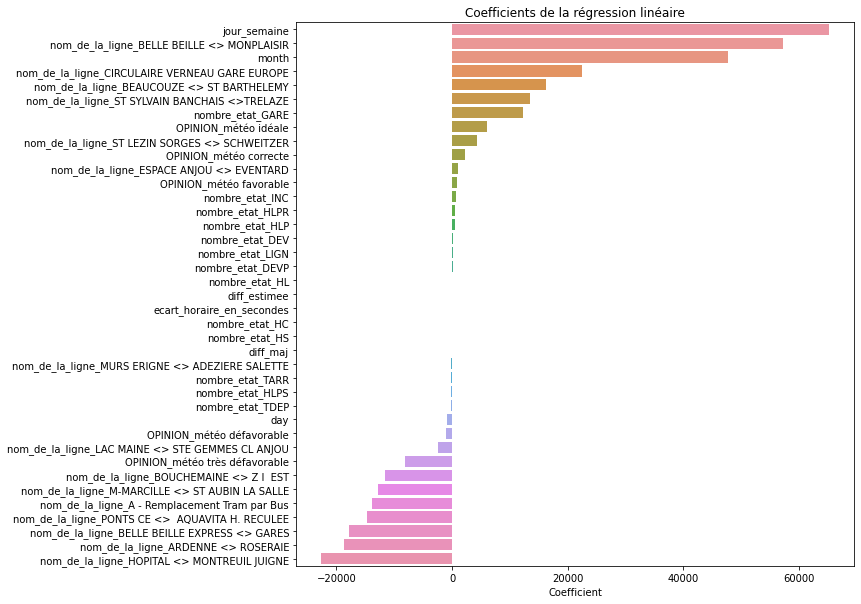

In [392]:
# Coefficients de la régression linéaire
coef_value = pd.DataFrame(lr.coef_, X_train.columns, columns=['Coefficient']).sort_values(by='Coefficient', ascending=False)

import seaborn as sns
fig = sns.barplot(x='Coefficient', y=coef_value.index, data=coef_value)
fig.set_title('Coefficients de la régression linéaire')
fig.figure.set_size_inches(10, 10)
fig

In [393]:
time_start = time.time()

param_grid = {'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, refit = True, verbose = 3, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["lr_grid", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END copy_X=True, fit_intercept=True, normalize=True;, score=0.686 total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, normalize=True;, score=0.645 total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, normalize=True;, score=0.686 total time=   0.0s
[CV 4/5] END copy_X=True, fit_intercept=True, normalize=True;, score=0.699 total time=   0.0s
[CV 5/5] END copy_X=True, fit_intercept=True, normalize=True;, score=0.688 total time=   0.0s
[CV 1/5] END copy_X=True, fit_intercept=True, normalize=False;, score=0.686 total time=   0.0s
[CV 2/5] END copy_X=True, fit_intercept=True, normalize=False;, score=0.645 total time=   0.0s
[CV 3/5] END copy_X=True, fit_intercept=True, normalize=False;, score=0.686 total time=   0.0s
[CV 4/5] END copy_X=True, fit_intercept=True, normalize=False;, score=0.699 total time=   0.0s
[CV 5/5] END copy_X=True, fit_intercept=True, normalize=False;, score=0.688 total time=   

C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/3463108573.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [394]:
from sklearn.linear_model import Ridge

time_start = time.time()

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["ridge", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

R2:  0.6965573006260151
MSE:  690103066.7938346
MAE:  20600.429227742577
MAPE:  0.5914648913309858


C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/3523288223.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [395]:
time_start = time.time()

param_grid = {'alpha': [0.1, 1, 10, 100, 1000], 'fit_intercept': [True, False], 'normalize': [True, False], 'copy_X': [True, False]}
grid = GridSearchCV(Ridge(), param_grid, refit = True, verbose = 3, cv=5)
grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["ridge_grid", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV 1/5] END alpha=0.1, copy_X=True, fit_intercept=True, normalize=True;, score=0.677 total time=   0.0s
[CV 2/5] END alpha=0.1, copy_X=True, fit_intercept=True, normalize=True;, score=0.655 total time=   0.0s
[CV 3/5] END alpha=0.1, copy_X=True, fit_intercept=True, normalize=True;, score=0.690 total time=   0.0s
[CV 4/5] END alpha=0.1, copy_X=True, fit_intercept=True, normalize=True;, score=0.700 total time=   0.0s
[CV 5/5] END alpha=0.1, copy_X=True, fit_intercept=True, normalize=True;, score=0.685 total time=   0.0s
[CV 1/5] END alpha=0.1, copy_X=True, fit_intercept=True, normalize=False;, score=0.686 total time=   0.0s
[CV 2/5] END alpha=0.1, copy_X=True, fit_intercept=True, normalize=False;, score=0.645 total time=   0.0s
[CV 3/5] END alpha=0.1, copy_X=True, fit_intercept=True, normalize=False;, score=0.686 total time=   0.0s
[CV 4/5] END alpha=0.1, copy_X=True, fit_intercept=True, normalize=False;, score=0.700 total ti

C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/2712223995.py:16: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [396]:
from sklearn.ensemble import RandomForestRegressor

time_start = time.time()

clf = RandomForestRegressor(n_estimators=100)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["RandomForestRegressor", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Pkl_Filename = "Model_1_full_regressor.pkl"  
with open(Pkl_Filename, 'wb') as file:  
    pickle.dump(clf, file)

R2:  0.8189820755054367
MSE:  411679124.57960004
MAE:  14551.430993377484
MAPE:  0.5192040494916208


C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/3145534522.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [397]:
time_start = time.time()

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

y_pred = grid_search.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["RandomForestRegressor", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
{'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 200}
R2:  0.7293957408199414
MSE:  615420405.6742656
MAE:  18736.17215265478
MAPE:  0.972281605780115


C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/1395810432.py:30: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [398]:
from sklearn.linear_model import SGDRegressor

time_start = time.time()

sgdr = SGDRegressor().fit(X_train, y_train)

y_pred = sgdr.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["SGDRegressor", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

R2:  -8.695048058351082e+26
MSE:  1.9774670286571727e+36
MAE:  1.1474466383231286e+18
MAPE:  26824728141282.35


C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/1390136564.py:17: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [399]:
# grid search SGDRegressor
from sklearn.model_selection import GridSearchCV

time_start = time.time()

param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'loss': ['huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'eta0': [0.01, 0.1, 1, 10, 100]
}

sgdr = SGDRegressor()
grid_search = GridSearchCV(estimator = sgdr, param_grid = param_grid,
                            cv = 3, n_jobs = -1, verbose = 2)
    
grid_search.fit(X_train, y_train)
y_pred = grid_search.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["SGDRegressor", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Fitting 3 folds for each of 1260 candidates, totalling 3780 fits
R2:  0.5363767003228269
MSE:  1054393009.304096
MAE:  24278.00638107669
MAPE:  1.4142395606197582


C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/3039309171.py:29: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [400]:
from sklearn.neural_network import MLPRegressor

time_start = time.time()

mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100), max_iter=1000, random_state=42)

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["MLPRegressor", "false", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

R2:  0.5043790121544768
MSE:  1127163594.264112
MAE:  23806.265961660392
MAPE:  0.81189591983637


C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/129790176.py:18: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [401]:
time_start = time.time()

param_grid = {'hidden_layer_sizes': [(100, 100, 100), (100, 100, 100, 100), (100, 100, 100, 100, 100)],
                'max_iter': [1000, 2000, 3000],
                'random_state': [42]}
grid = GridSearchCV(MLPRegressor(), param_grid, refit=True, verbose=3, n_jobs=-1)

grid.fit(X_train, y_train)
y_pred = grid.predict(X_test)

print("R2: ", r2_score(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MAPE: ", mean_absolute_percentage_error(y_test, y_pred))

time_end = time.time()

tab = ["MLPRegressor", "true", r2_score(y_test, y_pred), mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred), time_end - time_start]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
R2:  0.5094852699081744
MSE:  1115550712.6791
MAE:  23549.93435387875
MAPE:  0.8398190707352119


C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/2591508133.py:19: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [402]:
mean_pred = pd.Series([y_train.mean()] * len(y_test))

tab = ["Mean", "false", r2_score(y, mean_pred), mean_squared_error(y, mean_pred), mean_absolute_error(y, mean_pred), mean_absolute_percentage_error(y, mean_pred), 0]
df_result = df_result.append(pd.Series(tab, index=df_result.columns), ignore_index=True)

C:\Users\OKATRA~1\AppData\Local\Temp/ipykernel_2136/1246070978.py:4: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [403]:
df_result["Temps d'execution"] = df_result["Temps d'execution"].apply(lambda x: round(x, 2))

# export result to csv
df_result.to_csv("result.csv", index=False)


In [404]:
df_result

,model,CV,R2,MSE,MAE,MAPE,Temps d'execution
0,lr,false,6.944833e-01,6.948199e+08,2.069851e+04,6.061101e-01,0.01
1,lr_grid,true,6.946123e-01,6.945264e+08,2.069658e+04,6.057185e-01,0.17
2,ridge,false,6.965573e-01,6.901031e+08,2.060043e+04,5.914649e-01,0.01
3,ridge_grid,true,6.965573e-01,6.901031e+08,2.060043e+04,5.914649e-01,0.66
4,RandomForestRegressor,false,8.189821e-01,4.116791e+08,1.455143e+04,5.192040e-01,0.61
5,RandomForestRegressor,true,7.293957e-01,6.154204e+08,1.873617e+04,9.722816e-01,87.66
6,SGDRegressor,false,-8.695048e+26,1.977467e+36,1.147447e+18,2.682473e+13,0.01
7,SGDRegressor,true,5.363767e-01,1.054393e+09,2.427801e+04,1.414240e+00,19.58
8,MLPRegressor,false,5.043790e-01,1.127164e+09,2.380627e+04,8.118959e-01,0.41
9,MLPRegressor,true,5.094853e-01,1.115551e+09,2.354993e+04,8.398191e-01,25.16
